## Process Description

![Dietician](Assets/Simpy_Triage.png)

Simulate a process of people visiting a hospital and sent to ambulatory care (i.e. out-patient department) or to emergency care after triage. People visit the clinic, register at the front desk, then go to triage after which 20 percent are processed in ambulatory care and 80 percent assessed in emergency care.

1. **Entity**: People arriving for treatment
2. **Generator**: Generate arrivals  
3. **Inter-Arrrival Time**: An exponential distribution sampled for patient arrivals  
4. **Activity**: Registration followed by triage followed by assessment in ambulatory care (20 percent) or emergency care (80 percent)
5. **Activity Time**: Exponential distributions
6. **Resources**: Receptionist, nurse, doctor OPD, doctor ER
7. **Queues**: People waiting for registration after arrival, for triage after registration and for assessment after assignment to OPD or ER.
8. **Sink**: Exit after assessment.

Based on: https://youtu.be/QV-pJnKrGuc

### 1. Import packages

Aside from **simpy**, we need **random** to sample from random distributions.

In [157]:
import simpy
import random
import pandas as pd
from numpy import median
from matplotlib import pyplot as plt
import seaborn as sns
import warnings


### 2. Generate Arrivals

Define the generator for arrivals. This puts patients in the queue for consultation.

**Args**:
- env (Simpy environment) required
- mean_IAT (int) mean Inter-Arrival Time for generating arrivals
- meanCT2register (int) mean Cycle Time for registration
- meanCT2triage (int) mean Cycle Time for triage
- meanCT2assessnOPD (int) mean Cycle Time for assessment in OPD
- meanCT2assessnER (int) mean Cycle Time for assessment in ER
- receptionist (Simpy resource) resource
- nurse (Simpy resource) resource
- doctorOPD (Simpy resource) resource
- doctorER (Simpy resource) resource

**Notes**:
- Has a forever-while loop in which it:
	- Creates a patient ID and sends the patient onward on their journey, invoking the function that generates consultations with the patient's ID.
	- Has one ```yield``` statement to timeout for sampled Inter-Arrival Time, after which it increments patient ID. The ```yield``` with timeout will await the action (i.e. completion of timer), freezing until then and next resuming where it left off.

In [158]:
def generate_arrivals(env, mean_IAT, meanCT2register, meanCT2triage, meanCT2assessnOPD, meanCT2assessnER, 
                        receptionist, nurse, doctorOPD, doctorER):
    # Patient zero
    patient_ID = 0

    while True:
        # Send patient onward 
        generator_process_model = generate_process_model(env, meanCT2register, meanCT2triage, meanCT2assessnOPD, meanCT2assessnER, 
                        receptionist, nurse, doctorOPD, doctorER, patient_ID)
        env.process(generator_process_model)

        # Wait for next arrival
        delta4arrival = random.expovariate(1.0 / mean_IAT)
        yield env.timeout(delta4arrival)

        # Next patient
        patient_ID += 1

### 3. Generate Action

Define the generator for the process model.

**Args**:
- env (Simpy environment) required
- meanCT2register (int) mean Cycle Time for registration
- meanCT2triage (int) mean Cycle Time for triage
- meanCT2assessnOPD (int) mean Cycle Time for assessment in OPD
- meanCT2assessnER (int) mean Cycle Time for assessment in ER
- receptionist (Simpy resource) resource
- nurse (Simpy resource) resource
- doctorOPD (Simpy resource) resource
- doctorER (Simpy resource) resource
- patient_ID (int) patient ID from the function that generates arrivals

**Notes**: 
- For each activity in the process model, has two ```with``` declarations as follows:
    - Request the resource and ```yield``` until available
    - Execute the activity by timing out for sampled activity time. 
- Records timestamps at: arrived, queued for activity, started activity, exit
- The fork in the road is implemented by conditional logic that samples a uniform random distribution

In [159]:
def generate_process_model(env, meanCT2register, meanCT2triage, meanCT2assessnOPD, meanCT2assessnER, 
                        receptionist, nurse, doctorOPD, doctorER, patient_ID):
    global arrived4process
    global queued4registration
    global queued4triage
    global queued4assessmentOPD
    global queued4assessmentER
    global leadTimes

    arrived = env.now
    arrived4process.append(arrived)
    print("{} arrived at {:.2f}".format(patient_ID, arrived))

    # Request a receptionist for registration
    with receptionist.request() as req:
        # Wait until receptionist is available
        yield req

        startedRegistration = env.now
        queuedRegistration = startedRegistration - arrived
        queued4registration.append(queuedRegistration)
        print("{} started registration at {:.2f} after waiting {:.2f}".format(patient_ID, startedRegistration, queuedRegistration))
        
        deltaRegistration = random.expovariate(1.0 / mean_CT2register)
        yield env.timeout(deltaRegistration)

    arrived4triage = env.now

    with nurse.request() as req:
        # Wait until nurse is available
        yield req
        
        startedTriage = env.now
        queuedTriage = startedTriage - arrived4triage
        queued4triage.append(queuedTriage)
        print("{} started triage at {:.2f} after waiting {:.2f}".format(patient_ID, startedTriage, queuedTriage))

        deltaTriage = random.expovariate(1.0 / mean_CT2triage)
        yield env.timeout(deltaTriage)

    arrived4assessment = env.now

    which_way = random.uniform(0, 1)

    if (which_way < 0.2):
        with doctorOPD.request() as req:
            # Wait until doctor is available in outpatient care
            yield req

            startedAssessmentOPD = env.now
            queuedAssessmentOPD = startedAssessmentOPD - arrived4assessment
            queued4assessmentOPD.append(queuedAssessmentOPD)
            print("{} started assessment in outpatient care at {} after waiting {}".format(patient_ID, startedAssessmentOPD, queuedAssessmentOPD))            

            deltaAssessmentOPD = random.expovariate(1.0 / mean_CT2assessOPD)
            yield env.timeout(deltaAssessmentOPD)
    else:
        with doctorER.request() as req:
            # Wait until doctor is available for inpatient care
            yield req

            startedAssessmentER = env.now
            queuedAssessmentER = startedAssessmentER - arrived4assessment
            queued4assessmentER.append(queuedAssessmentER)
            print("{} started asessment in inpatient care at {} after waiting {}".format(patient_ID, startedAssessmentER, queuedAssessmentER))
            
            deltaAssessmentER = random.expovariate(1.0 / mean_CT2assessER)
            yield env.timeout(deltaAssessmentER)

            exited = env.now    
            TAT = exited - arrived
            leadTimes.append(TAT)
            print("{} HAD LEAD TIME OF {:.0f} MINUTES.".format(patient_ID, TAT))

                        

### 3. Simulate One Run

Take a test drive.

In [160]:
# Set up the simulation environment
env = simpy.Environment()

# Set up the resources
receptionist = simpy.Resource(env, capacity=1)
nurse = simpy.Resource(env, capacity=2)
doctorOPD = simpy.Resource(env, capacity=1)
doctorER = simpy.Resource(env, capacity=2)

# Configure simulation parameters
mean_IAT = 8
mean_CT2register = 2
mean_CT2triage = 5
mean_CT2assessOPD = 60
mean_CT2assessER = 30

# Lists of Globals
arrived4process = []
queued4registration = []    
delta4registration = []         # Not used
queued4triage = []
delta4triage = []               # Not used
queued4assessmentOPD = []
delta4assessmentOPD = []        # Not used
queued4assessmentER = []
delta4assessmentER = []         # Not used
leadTimes = []

# Make it so
env.process(generate_arrivals(env, mean_IAT, mean_CT2register, mean_CT2triage, mean_CT2assessOPD, mean_CT2assessER,
                            receptionist, nurse, doctorOPD, doctorER))
env.run(until=480)

print(leadTimes)
print("Median time queued in | registration    | is {}".format(median(queued4registration)))
print("Median time queued in | triage          | is {}".format(median(queued4triage)))
print("Median time queued in | assessment OPD  | is {}".format(median(queued4assessmentOPD)))
print("Median time queued in | assessment ER   | is {}".format(median(queued4assessmentER)))
print("Median time queued in | START 2 FINISH  | is {}".format(median(leadTimes)))


0 arrived at 0.00
0 started registration at 0.00 after waiting 0.00
0 started triage at 1.95 after waiting 0.00
1 arrived at 3.73
1 started registration at 3.73 after waiting 0.00
0 started assessment in outpatient care at 3.9583856898940932 after waiting 0.0
2 arrived at 9.74
1 started triage at 17.71 after waiting 0.00
2 started registration at 17.71 after waiting 7.97
1 started asessment in inpatient care at 19.68152148891763 after waiting 0.0
2 started triage at 20.56 after waiting 0.00
2 started asessment in inpatient care at 22.83254422687674 after waiting 0.0
3 arrived at 23.00
3 started registration at 23.00 after waiting 0.00
4 arrived at 23.80
3 started triage at 24.88 after waiting 0.00
4 started registration at 24.88 after waiting 1.08
5 arrived at 25.60
4 started triage at 26.46 after waiting 0.00
5 started registration at 26.46 after waiting 0.86
6 arrived at 28.80
5 started triage at 29.74 after waiting 0.00
6 started registration at 29.74 after waiting 0.94
6 started tr

### 4. Visualize Single Run

Sanity check with Gantt chart.

In [161]:
gantt = zip(arrived4process, leadTimes)
g150 = list(gantt)[:150] 

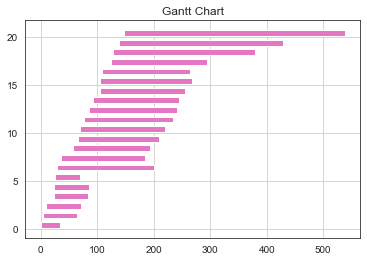

In [162]:
fig, gnt = plt.subplots()
gnt.set_title("Gantt Chart")
gnt.grid(True)

idx_y = 0.1
for i in g150:
    gnt.broken_barh([i], (idx_y, 0.6), facecolors=('tab:pink'))
    idx_y += 1

### 5. Average Over Runs

Average over multiple runs. Our information-gathering strategy is to have the time of arrival, end-end lead time and time spent in queue at each step. We shall not collect processing time at any step as this is modeled and hence redundant to collect. In our analysis, we shall examine queues to identify bottlnecks.

In [163]:
# Initialize dashboard
number_runs = 30
simulation_horizon = 480
simulation_results = []

# for loop 
for i in range(0, number_runs):
    run_result = {
        "TAT": None,
        "Queued4Registration": None,
        "Queued4Triage": None,
        "Queued4AssessmentOPD": None,
        "Queued4AssessmentER": None
    }
    # Set up the simulation environment
    env = simpy.Environment()

    # Set up the resources
    receptionist = simpy.Resource(env, capacity=1)
    nurse = simpy.Resource(env, capacity=2)
    doctorOPD = simpy.Resource(env, capacity=1)
    doctorER = simpy.Resource(env, capacity=2)

    # Configure simulation parameters
    mean_IAT = 8
    mean_CT2register = 2
    mean_CT2triage = 5
    mean_CT2assessOPD = 60
    mean_CT2assessER = 30

    # Lists of Globals
    arrived4process = []
    queued4registration = []    
    delta4registration = []         # Not used
    queued4triage = []
    delta4triage = []               # Not used
    queued4assessmentOPD = []
    delta4assessmentOPD = []        # Not used
    queued4assessmentER = []
    delta4assessmentER = []         # Not used
    leadTimes = []

    # Make it so
    env.process(generate_arrivals(env, mean_IAT, mean_CT2register, mean_CT2triage, mean_CT2assessOPD, mean_CT2assessER,
                                receptionist, nurse, doctorOPD, doctorER))
    env.run(until=simulation_horizon)

    run_result["TAT"] = sum(leadTimes) / len(leadTimes)
    run_result["Queued4Registration"] = sum(queued4registration) / len(queued4registration)
    run_result["Queued4Triage"] = sum(queued4triage) / len(queued4triage)
    run_result["Queued4AssessmentOPD"] = sum(queued4assessmentOPD) / len(queued4assessmentOPD)
    run_result["Queued4AssessmentER"] = sum(queued4assessmentER) / len(queued4assessmentER)
    simulation_results.append(run_result)

# Plot & Print
df = pd.DataFrame(simulation_results)
    

0 arrived at 0.00
0 started registration at 0.00 after waiting 0.00
0 started triage at 2.85 after waiting 0.00
1 arrived at 11.44
1 started registration at 11.44 after waiting 0.00
0 started assessment in outpatient care at 13.360512549863799 after waiting 0.0
1 started triage at 14.30 after waiting 0.00
1 started asessment in inpatient care at 15.945728786138758 after waiting 0.0
2 arrived at 18.01
2 started registration at 18.01 after waiting 0.00
2 started triage at 20.86 after waiting 0.00
1 HAD LEAD TIME OF 9 MINUTES.
3 arrived at 21.62
3 started registration at 21.62 after waiting 0.00
3 started triage at 22.65 after waiting 0.00
4 arrived at 32.20
4 started registration at 32.20 after waiting 0.00
4 started triage at 32.82 after waiting 0.00
4 started asessment in inpatient care at 33.948385090266704 after waiting 0.0
5 arrived at 40.27
5 started registration at 40.27 after waiting 0.00
5 started triage at 41.51 after waiting 0.00
5 started asessment in inpatient care at 42.205

### 6. Visualize Results

Plot the times spent in queue at each of the processing steps. 

In [164]:
# What's in the spreadsheet?
df.head()

,TAT,Queued4Registration,Queued4Triage,Queued4AssessmentOPD,Queued4AssessmentER
0,133.069480,0.410785,0.646830,29.406056,100.120981
1,121.538414,0.380203,1.531107,13.973653,81.038280
2,135.419641,0.147926,0.085941,19.506829,105.713811
3,135.797173,0.434258,0.701617,205.350993,106.248906
4,67.814517,0.780238,0.215560,181.758288,36.859387


Text(0.5, 0, 'Time')

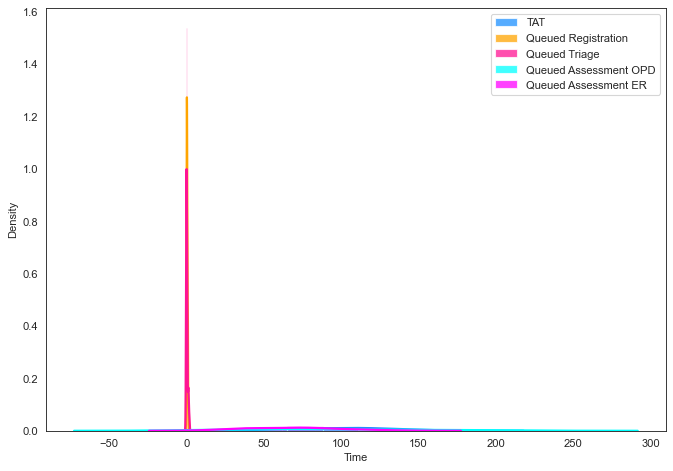

In [165]:
# Plot the histogram and density function - all steps and TAT
warnings.filterwarnings('ignore')
sns.set_style("white")
kwargs = {"hist_kws": {'alpha': 0.75}, "kde_kws": {'linewidth': 2}}
plt.figure(figsize=(10,7), dpi=80)
sns.distplot(df.TAT, color="dodgerblue", label="TAT", **kwargs)
sns.distplot(df.Queued4Registration, color="orange", label="Queued Registration", **kwargs)
sns.distplot(df.Queued4Triage, color="deeppink", label="Queued Triage", **kwargs)
sns.distplot(df.Queued4AssessmentOPD, color="cyan", label="Queued Assessment OPD", **kwargs)
sns.distplot(df.Queued4AssessmentER, color="magenta", label="Queued Assessment ER", **kwargs)
plt.legend()
plt.xlabel("Time")

<AxesSubplot:xlabel='ER', ylabel='Density'>

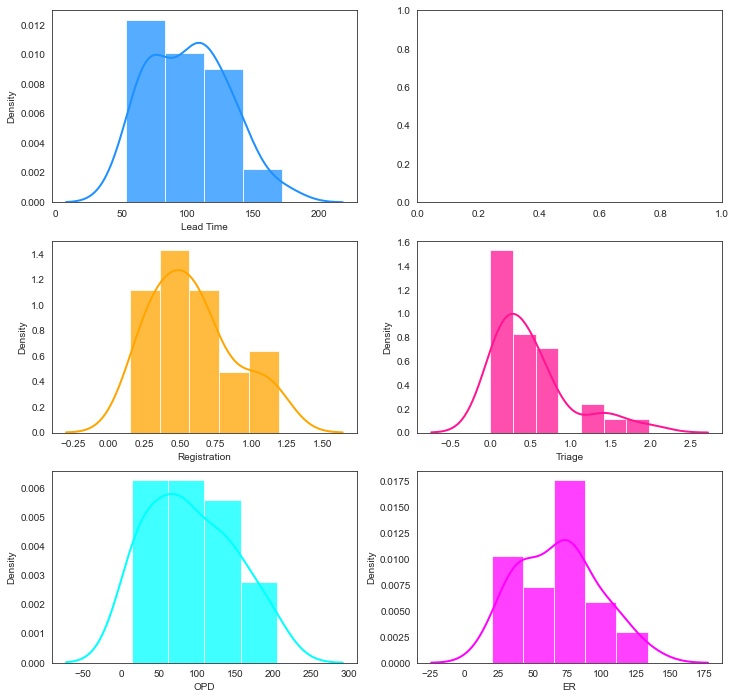

In [166]:
fig, axs = plt.subplots(3, 2)
fig.set_figwidth(12)
fig.set_figheight(12)

sns.set_style("white")
kwargs = {"hist_kws": {'alpha': 0.75}, "kde_kws": {'linewidth': 2}}
sns.distplot(df.TAT, color="dodgerblue", ax=axs[0,0], axlabel="Lead Time", **kwargs)
sns.distplot(df.Queued4Registration, color="orange", ax=axs[1,0], axlabel="Registration", **kwargs)
sns.distplot(df.Queued4Triage, color="deeppink", ax=axs[1,1], axlabel="Triage", **kwargs)
sns.distplot(df.Queued4AssessmentOPD, color="cyan", ax=axs[2,0], axlabel="OPD", **kwargs)
sns.distplot(df.Queued4AssessmentER, color="magenta", ax=axs[2,1], axlabel="ER",**kwargs)

### Conclusion and Next Steps

The analysis shows waiting times are significantly larger for assessment in OPD or ER than in reception or triage. We can now explore remediation scenarios with Streamlit.